In [1]:
######################################################################################################
## Etapa 0: Importando as bibliotecas necessárias
######################################################################################################
import os
import time

from concurrent.futures import ThreadPoolExecutor
from src.modules.image import Image, display_image
from src.modules.detection import Detection, plot_detection
from src.modules.canny import Canny
from src.modules.adjacency_matrix import AdjacencyMatrix
from src.modules.connected_components import ConnectedComponents, highlight_components
from src.modules.mst import MinimunSpanningTree
from src.modules.build_tree import BuildTree, plot_logest_path
from src.modules.compute_splines import ComputeSplines, plot_splines

In [3]:
def process_image(file_path):
    try:
        start_step1 = time.time()
        print("Etapa 1: Leitura da imagem")
        img = Image(file_path)
        img.reading_image()
        end_step1 = time.time()


        # Etapa 2: Detecção de características
        print("Etapa 2: Detecção de características")
        detection = Detection(img.gray_image)
        detection.compute_all_detections()
        end_step2 = time.time()


        # Etapa 3: Detecção de bordas
        print("Etapa 3: Detecção de bordas")
        canny = Canny(detection.mouth.img, detection.nose.img, detection.left_eye.img, detection.right_eye.img)
        canny.compute_all_edges()
        end_step3 = time.time()


        # Etapa 4: Criação das matrizes de adjacência
        print("Etapa 4: Criação das matrizes de adjacência")
        adjacency_matrix = AdjacencyMatrix(canny.mouth_dict, canny.nose_dict, canny.left_eye_dict, canny.right_eye_dict)
        adjacency_matrix.compute_all_matrices()
        end_step4 = time.time()

        # Etapa 5: Cálculo de componentes conectados para cada matriz
        print("Etapa 5: Cálculo de componentes conectados para cada matriz")
        components_results = ConnectedComponents(adjacency_matrix.nose_adjacency_matrix, adjacency_matrix.mouth_adjacency_matrix, adjacency_matrix.left_eye_adjacency_matrix, adjacency_matrix.right_eye_adjacency_matrix)
        components_results.compute_all_components()
        components_results.compute_main_cc()
        end_step5 = time.time()
        # Etapa 6: Cálculo da árvore geradora mínima
        print("Etapa 6: Cálculo da árvore geradora mínima")
        mst = MinimunSpanningTree(components_results.dic_main_nose_cc, components_results.dic_main_mouth_cc, components_results.dic_main_left_eye_cc, components_results.dic_main_right_eye_cc,
                                  adjacency_matrix.nose_adjacency_matrix, adjacency_matrix.mouth_adjacency_matrix, adjacency_matrix.left_eye_adjacency_matrix, adjacency_matrix.right_eye_adjacency_matrix)
        mst.compute_all_mst()
        end_step6 = time.time()
        # Etapa 7: Construção da árvore e poda
        print("Etapa 7: Construção da árvore e poda")
        tree = BuildTree(mst.min_trees_nose, mst.min_trees_mouth, mst.min_trees_left_eye, mst.min_trees_right_eye)
        tree.compute_all_trees()
        end_step7 = time.time()
        # Etapa 8: Splines
        print("Etapa 8: Splines")
        splines = ComputeSplines(tree.new_longest_path_nose, tree.new_longest_path_mouth, tree.new_longest_path_left_eye, tree.new_longest_path_right_eye,
                                 mst.nodes_nose, mst.nodes_mouth, mst.nodes_left_eye, mst.nodes_right_eye,
                                 canny.nose_dict, canny.mouth_dict, canny.left_eye_dict, canny.right_eye_dict,
                                 mst.idx_nose, mst.idx_mouth, mst.idx_left_eye, mst.idx_right_eye)
        splines.compute_all_splines()
        end_step8 = time.time()

        

        print(f"Processado: {file_path}")
        print(f"Tempo1 {end_step1 - start_step1}\nTempo2 {end_step2 - end_step1}\nTempo3 {end_step3 - end_step2}\nTempo4 {end_step4 - end_step3}\nTempo5 {end_step5 - end_step4}\nTempo6 {end_step6 - end_step5}\nTempo7 {end_step7 - end_step6}\nTempo8 {end_step8 - end_step7}")
        return img, detection, canny, adjacency_matrix, components_results, mst, tree, splines

    except Exception as e:
        print(f"Erro ao processar {file_path}: {e}")
        return None

    
    
directory = './image'

file_paths = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(('pedro.jpg'))]

with ThreadPoolExecutor(max_workers=5) as executor:
    results = list(executor.map(process_image, file_paths))



Etapa 1: Leitura da imagem
Etapa 2: Detecção de características
Face detection: 0.06482338905334473
Nose detection: 0.10099101066589355
Mouth detection: 0.06383514404296875
Eye detection: 0.019328832626342773
Etapa 3: Detecção de bordas
Etapa 4: Criação das matrizes de adjacência
Etapa 5: Cálculo de componentes conectados para cada matriz
Etapa 6: Cálculo da árvore geradora mínima
Etapa 7: Construção da árvore e poda
Etapa 8: Splines
Processado: ./image\pedro.jpg
Tempo1 0.011968612670898438
Tempo2 0.2489783763885498
Tempo3 0.004032135009765625
Tempo4 0.14110207557678223
Tempo5 0.02334451675415039
Tempo6 0.013915300369262695
Tempo7 0.036597490310668945
Tempo8 0.0338594913482666


In [ ]:
# import cv2
# import time

# class FaceFeature:
#     def __init__(self, img, x, y, w, h):
#         self.img = img
#         self.x = x
#         self.y = y
#         self.w = w
#         self.h = h

# class Detection:
#     def __init__(self, gray_image):
#         self.gray_image = gray_image
#         self.face = None
#         self.nose = None
#         self.mouth = None
#         self.left_eye = None
#         self.right_eye = None

#     def detect_face(self):
#         face_cascade = cv2.CascadeClassifier('models/haarcascade_frontalface_default.xml')
#         faces = face_cascade.detectMultiScale(self.gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(40,50))
#         for (x,y,w,h) in faces:
#             face = FaceFeature(self.gray_image[y:y+h, x:x+w], x, y, w, h)
    
#         return face
        
#     def detect_nose(self):
#         nose_cascade = cv2.CascadeClassifier('models/haarcascade_mcs_nose.xml')
#         noses = nose_cascade.detectMultiScale(self.face.img, scaleFactor=1.1, minNeighbors=5, minSize=(40,50))
#         for (x,y,w,h) in noses:
#             nose = FaceFeature(self.face.img[y:y+h, x:x+w], x, y, w, h)

#         return nose
    
#     def detect_mouth(self):
#         mouth_cascade = cv2.CascadeClassifier('models/haarcascade_mcs_mouth.xml')
#         mouths = mouth_cascade.detectMultiScale(self.face.img, scaleFactor=1.1, minNeighbors=5, minSize=(40,50))
#         for (x,y,w,h) in mouths:
#             mouth = FaceFeature(self.face.img[y:y+h, x:x+w], x, y, w, h)
#             face_without_mouth = self.face.img.copy()
#             face_without_mouth[y:y+h, x:x+w] = 0
#             face_without_mouth = FaceFeature(face_without_mouth, x, y, w, h)
        
#         return mouth, face_without_mouth
    
#     def detect_eyes(self):
#         eye_cascade = cv2.CascadeClassifier('models/haarcascade_eye.xml')
#         eyes = eye_cascade.detectMultiScale(self.face_without_mouth.img, scaleFactor=1.1, minNeighbors=5, minSize=(40,50))
#         if len(eyes) >= 2:
#             eyes = sorted(eyes, key=lambda x: x[0])
#             x1, y1, w1, h1 = eyes[0]
#             x2, y2, w2, h2 = eyes[1]
#             left_eye = FaceFeature(self.face_without_mouth.img[y1:y1+h1, x1:x1+w1], x1, y1, w1, h1)
#             right_eye = FaceFeature(self.face_without_mouth.img[y2:y2+h2, x2:x2+w2], x2, y2, w2, h2)

#         else:
#             print("Olhos não detectados")
        
#         return left_eye, right_eye


        
#     def compute_all_detections(self):
#         start = time.time()
#         self.face = self.detect_face()
#         end_face = time.time()
#         self.nose = self.detect_nose()
#         end_nose = time.time()
#         self.mouth, self.face_without_mouth = self.detect_mouth()
#         end_mouth = time.time()
#         self.left_eye, self.right_eye = self.detect_eyes()

#         # end_eye = time.time()
#         # print(f"Face detection: {end_face - start}\nNose detection: {end_nose - end_face}\nMouth detection: {end_mouth - end_nose}\nEye detection: {end_eye - end_mouth}")

In [17]:
img = cv2.imread('image/pedro.jpg')
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
detection = Detection(gray_image)
detection.compute_all_detections()

cv2.imshow("teste", detection.face.img)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imshow("teste", detection.nose.img)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imshow("teste", detection.mouth.img)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imshow("teste", detection.left_eye.img)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imshow("teste", detection.right_eye.img)


cv2.waitKey(0)
cv2.destroyAllWindows()

In [54]:
import cv2
img = cv2.imread('image/pedro.jpg')
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
face = cv2.CascadeClassifier("models/haarcascade_frontalface_default.xml")
nose = cv2.CascadeClassifier("models/haarcascade_mcs_nose.xml")
mouth = cv2.CascadeClassifier("models/haarcascade_mcs_mouth.xml")
eye = cv2.CascadeClassifier("models/haarcascade_eye.xml")

faces = face.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(40, 50))
# quero primeiro detectar o rosto e cortar a imagem, depois identificar a boca dentro da imagem do rosto, depois recortar a imagem da boca e identificar os olhos fora da boca e dentro do rosto

for (x, y, w, h) in faces:
    roi_face = gray_image[y:y+h, x:x+w]
    cv2.imshow('face', roi_face)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

noses = nose.detectMultiScale(roi_face, scaleFactor=1.1, minNeighbors=5, minSize=(40, 50))
for (x, y, w, h) in noses:

    roi_nose = roi_face[y:y+h, x:x+w]
    cv2.imshow('nose', roi_nose)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

mouths = mouth.detectMultiScale(roi_face, scaleFactor=1.1, minNeighbors=5, minSize=(40, 50))
for (x, y, w, h) in mouths:

    roi_mouth = roi_face[y:y+h, x:x+w]
    cv2.imshow('mouth', roi_mouth)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

face_without_mouth = roi_face.copy()
face_without_mouth[y:y+h, x:x+w] = 0

eyes = eye.detectMultiScale(face_without_mouth, scaleFactor=1.1, minNeighbors=5, minSize=(40, 50))
eyes = sorted(eyes, key=lambda x: x[0])
x1, y1, w1, h1 = eyes[0]
x2, y2, w2, h2 = eyes[1]
roi_left_eye = face_without_mouth[y1:y1+h1, x1:x1+w1]
roi_right_eye = face_without_mouth[y2:y2+h2, x2:x2+w2]

cv2.imshow('left eye', roi_left_eye)
cv2.imshow('right eye', roi_right_eye)
cv2.waitKey(0)
cv2.destroyAllWindows()



ValueError: operands could not be broadcast together with shapes (236,236) (62,103) 

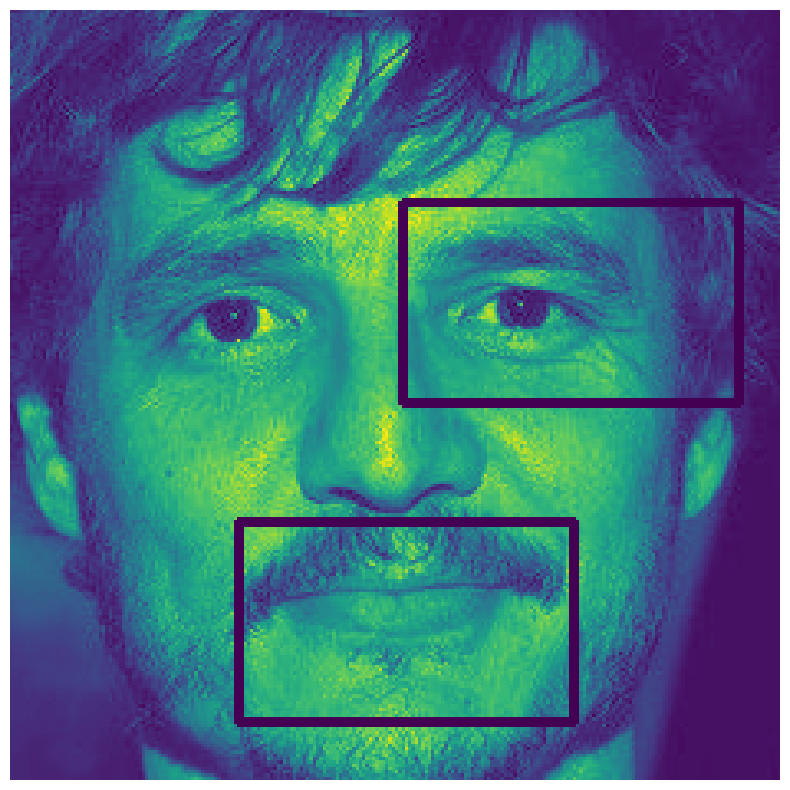

In [44]:
display_image(face_detect)

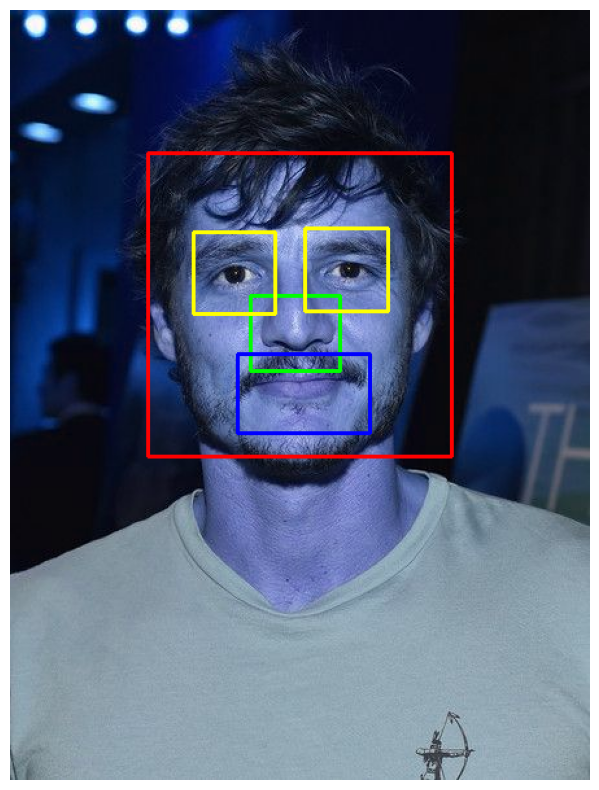

In [9]:
if detection is not None:
    if detection.face is not None:
        x, y, w, h = detection.face.x, detection.face.y, detection.face.w, detection.face.h
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
    if detection.nose is not None:
        x, y, w, h = detection.face.x + detection.nose.x, detection.face.y + detection.nose.y, detection.nose.w, detection.nose.h
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    if detection.mouth is not None:
        x, y, w, h = detection.face.x + detection.mouth.x, detection.face.y + detection.mouth.y, detection.mouth.w, detection.mouth.h
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
    if detection.left_eye is not None:
        x, y, w, h = detection.face.x + detection.left_eye.x, detection.face.y + detection.left_eye.y, detection.left_eye.w, detection.left_eye.h
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 255, 0), 2)
    if detection.right_eye is not None:
        x, y, w, h = detection.face.x + detection.right_eye.x, detection.face.y + detection.right_eye.y, detection.right_eye.w, detection.right_eye.h
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 255, 0), 2)

display_image(img)

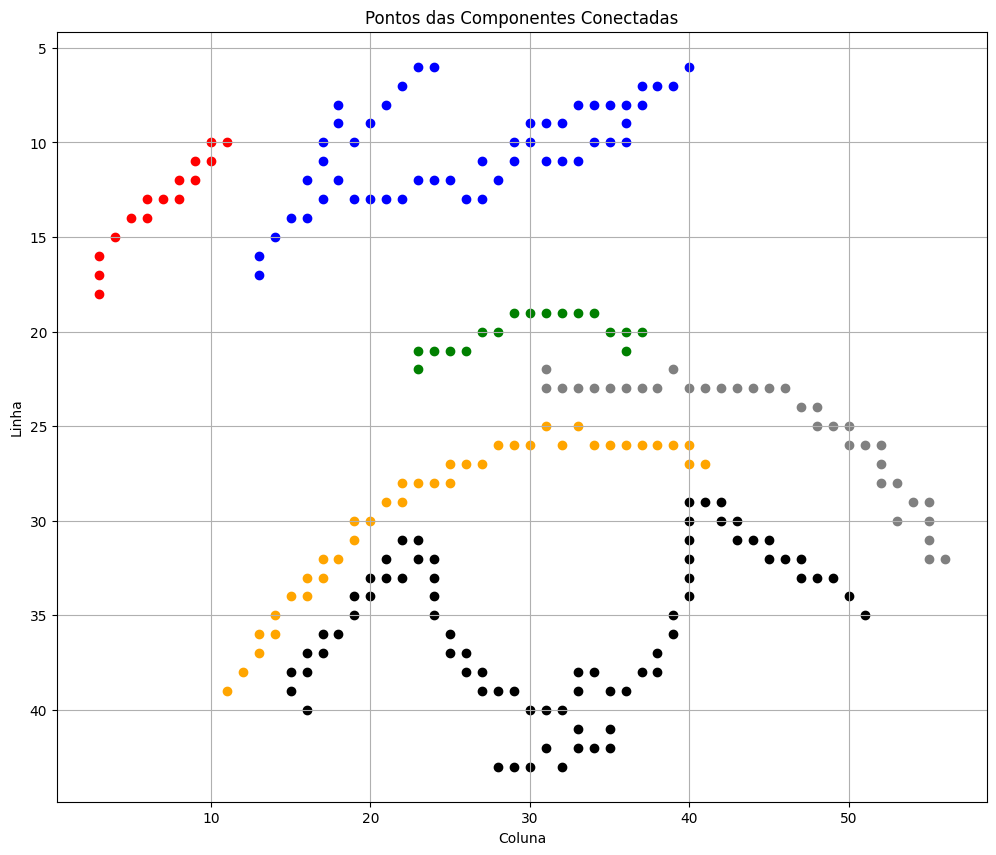

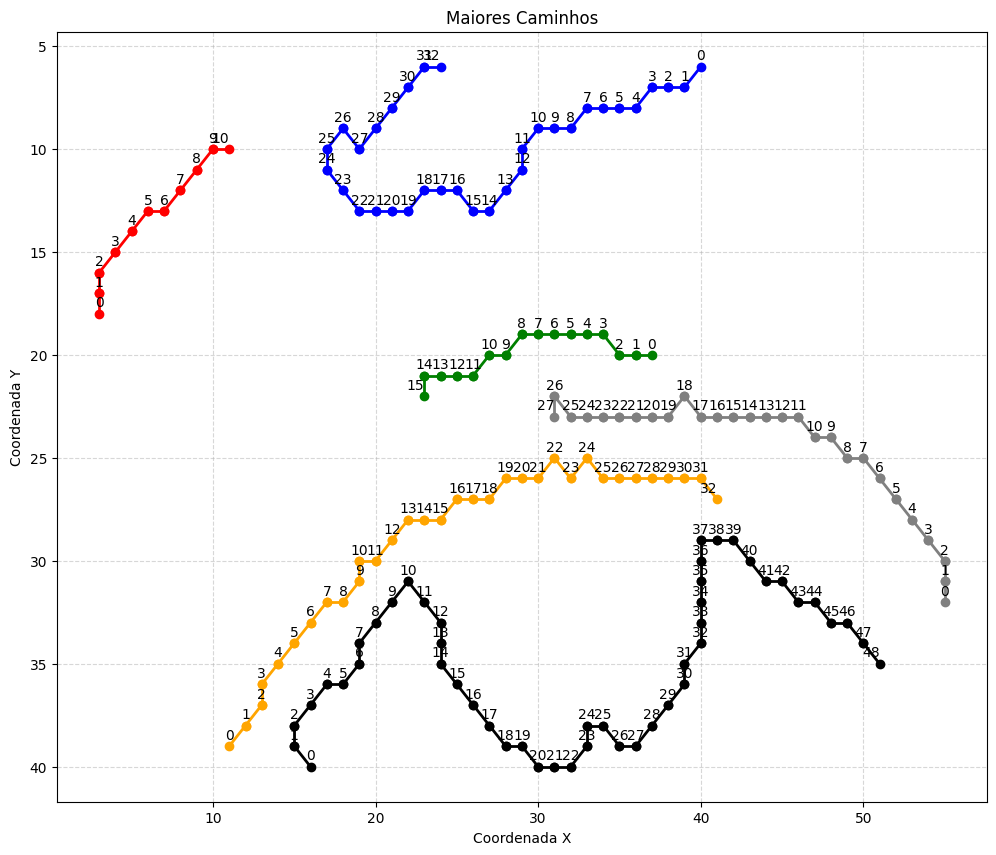

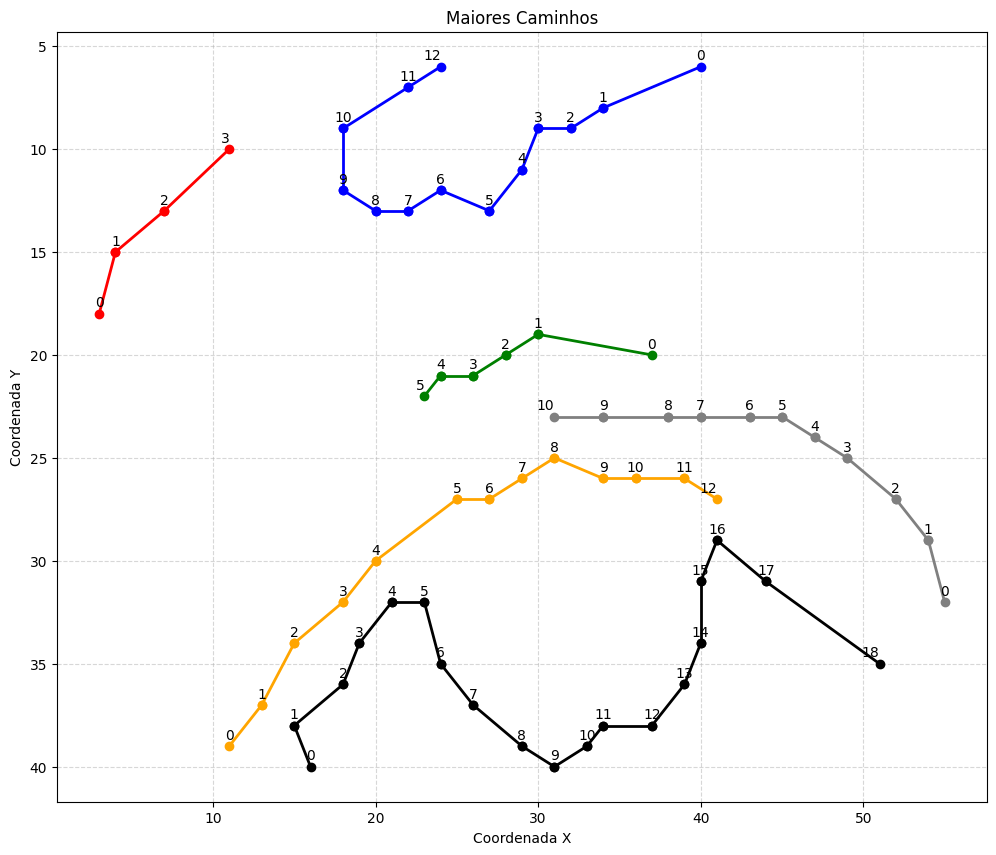

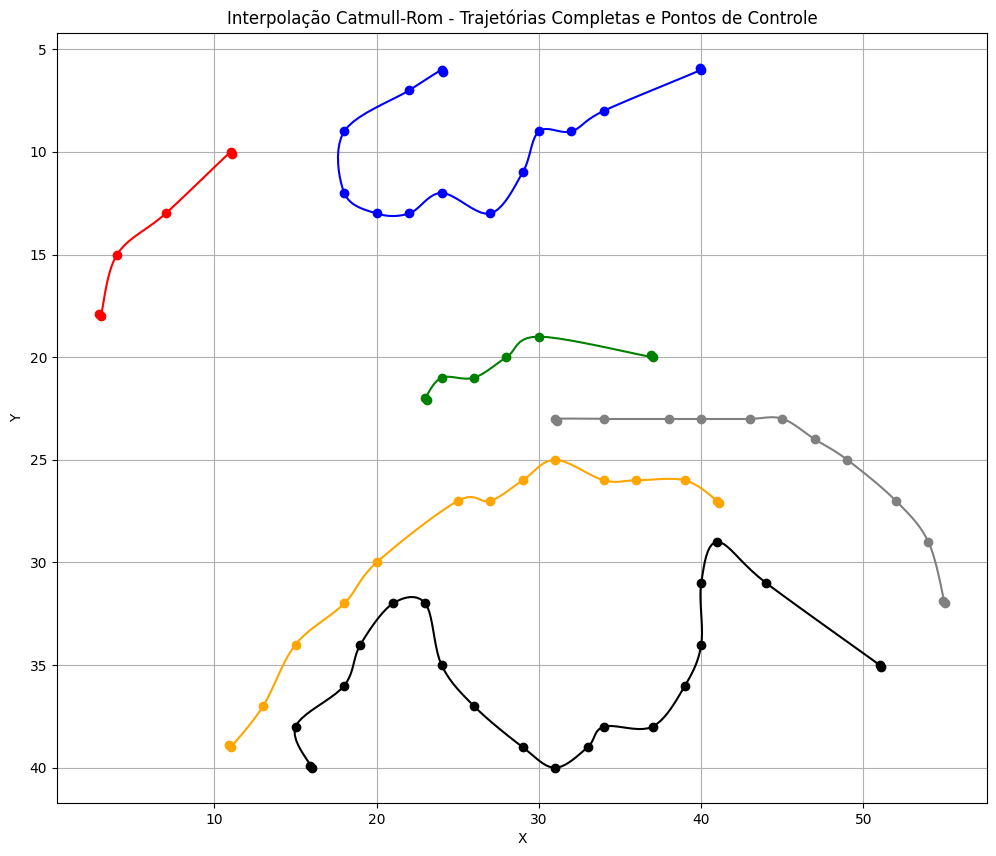

In [6]:
highlight_components(results[0][2].left_eye_dict, results[0][4].dic_main_left_eye_cc)
plot_logest_path(results[0][2].left_eye_dict, results[0][6].longest_path_left_eye, results[0][5].nodes_left_eye)
plot_logest_path(results[0][2].left_eye_dict, results[0][6].new_longest_path_left_eye, results[0][5].nodes_left_eye)
plot_splines(results[0][7].all_X_left_eye, results[0][7].all_Y_left_eye, results[0][7].all_control_x_left_eye, results[0][7].all_control_y_left_eye)


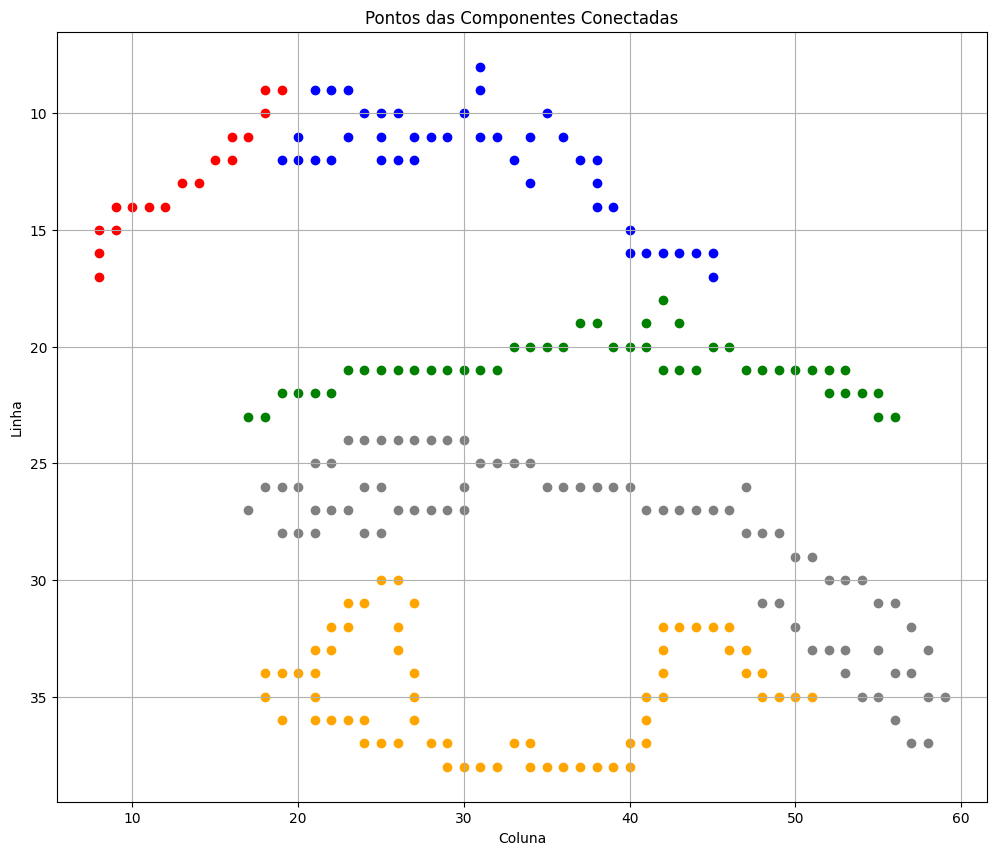

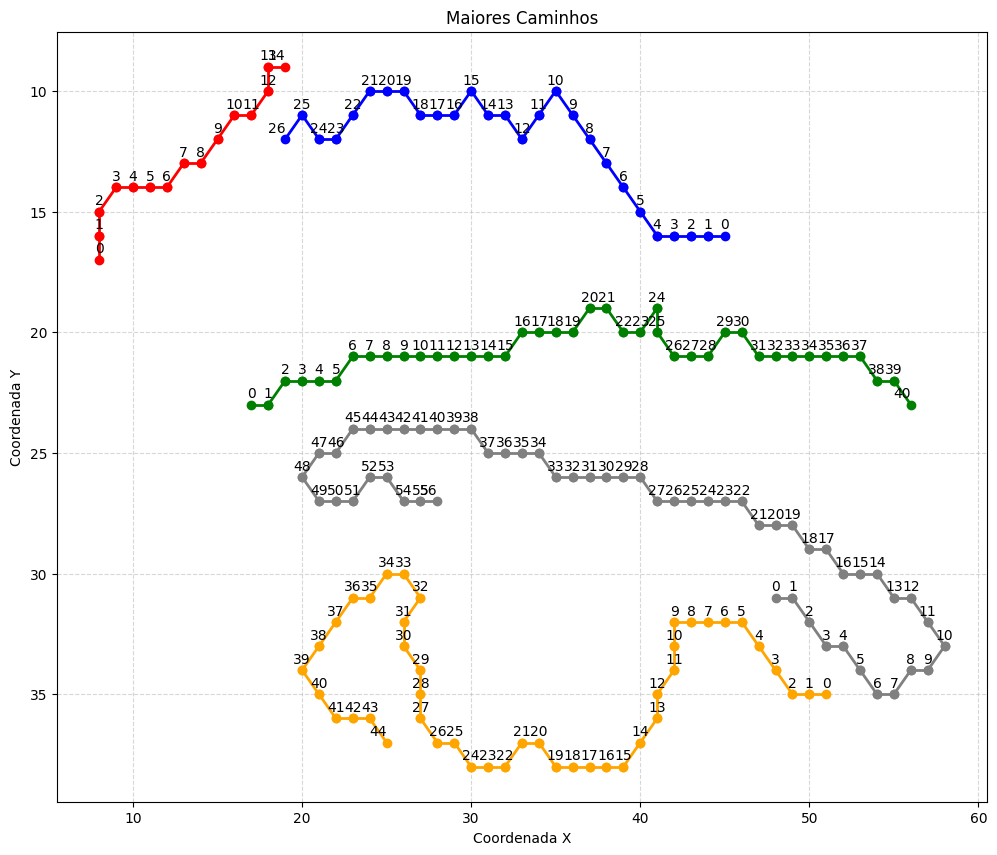

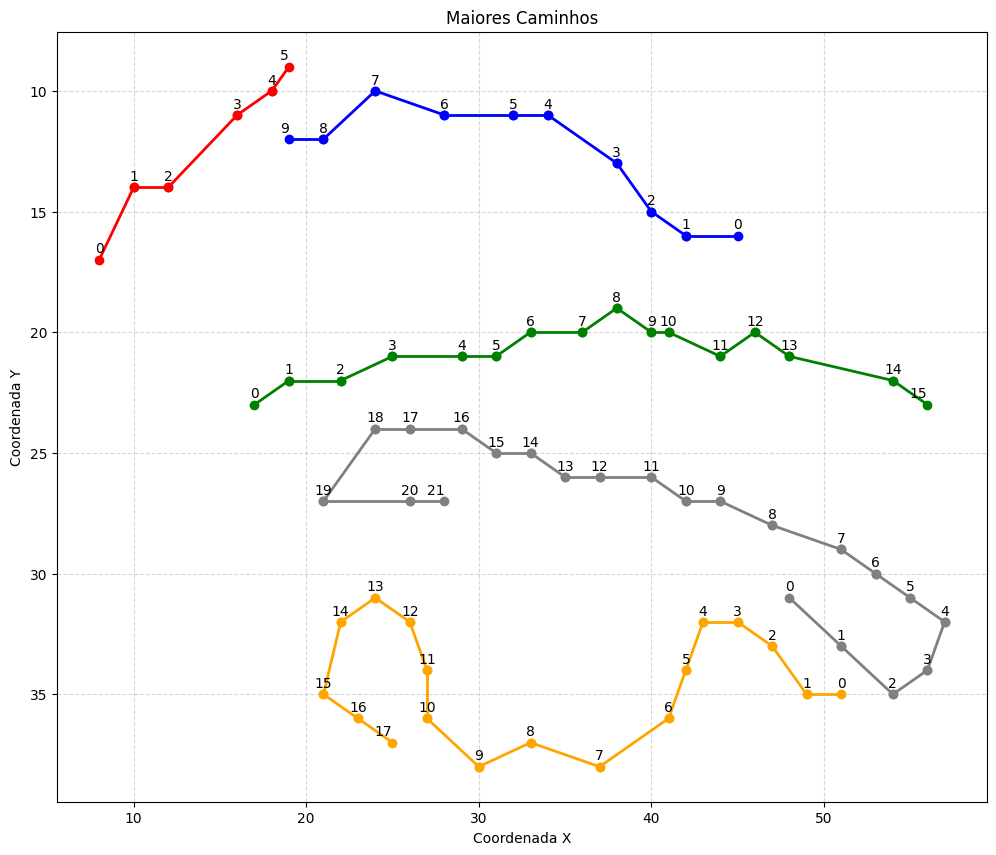

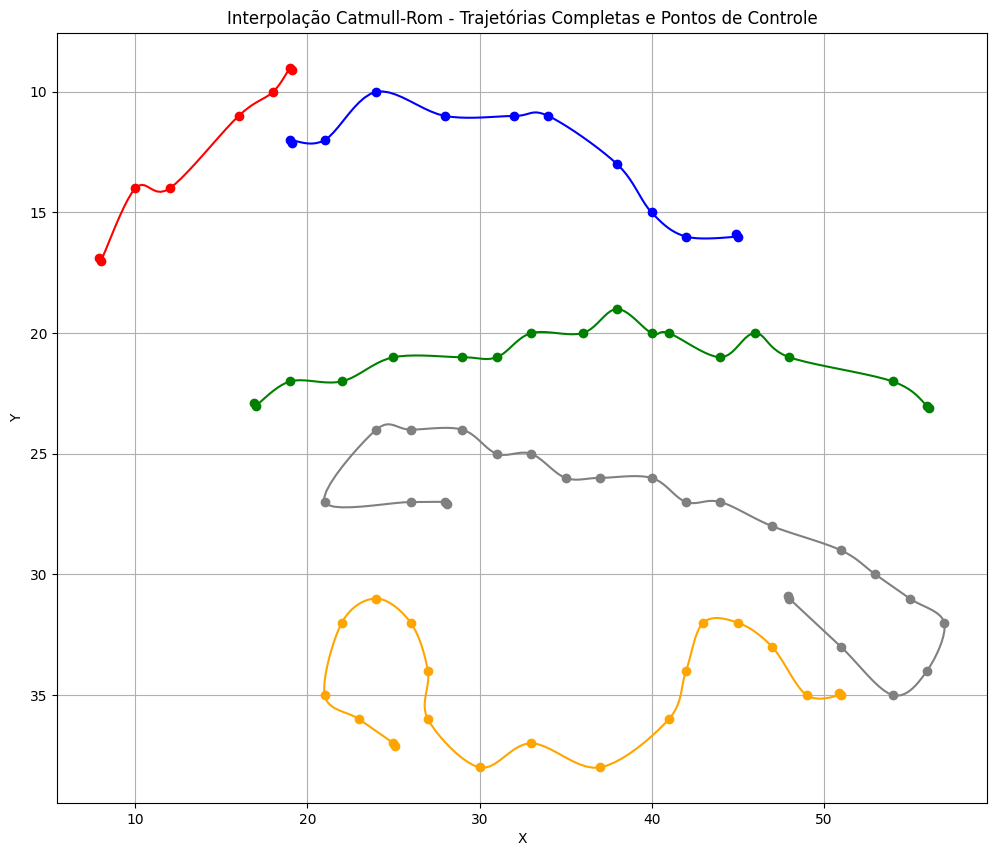

In [4]:
highlight_components(results[0][2].right_eye_dict, results[0][4].dic_main_right_eye_cc)
plot_logest_path(results[0][2].right_eye_dict, results[0][6].longest_path_right_eye, results[0][5].nodes_right_eye)
plot_logest_path(results[0][2].right_eye_dict, results[0][6].new_longest_path_right_eye, results[0][5].nodes_right_eye)
plot_splines(results[0][7].all_X_right_eye, results[0][7].all_Y_right_eye, results[0][7].all_control_x_right_eye, results[0][7].all_control_y_right_eye)


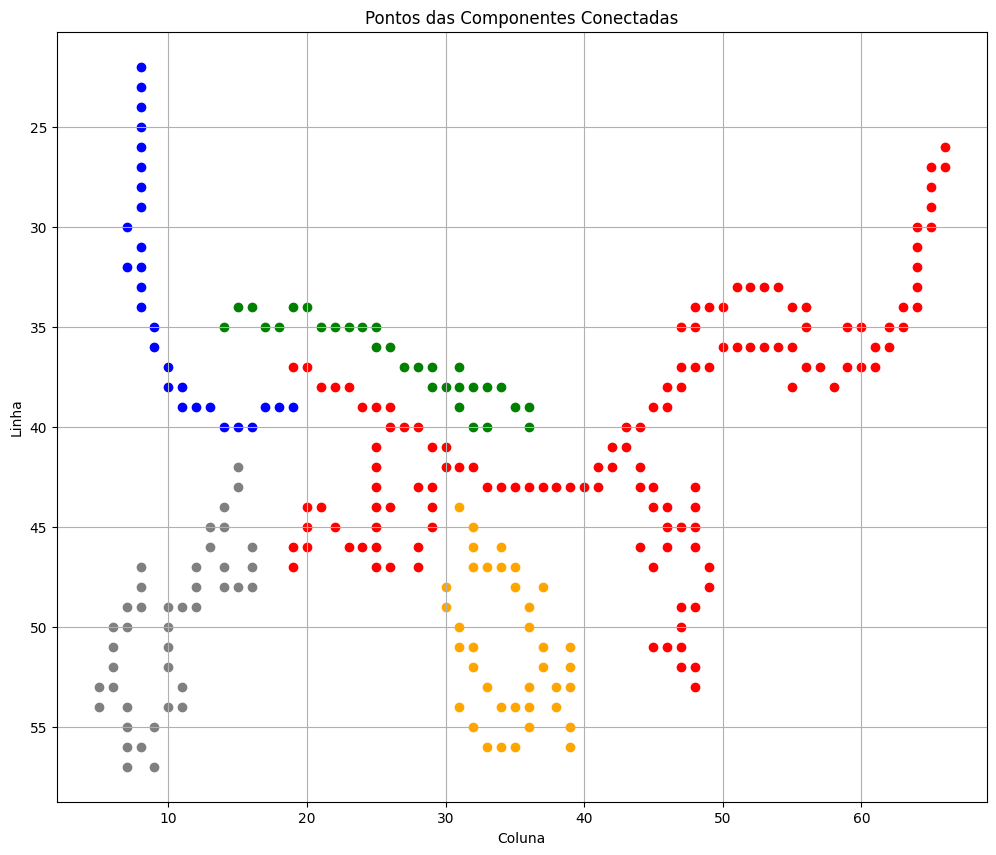

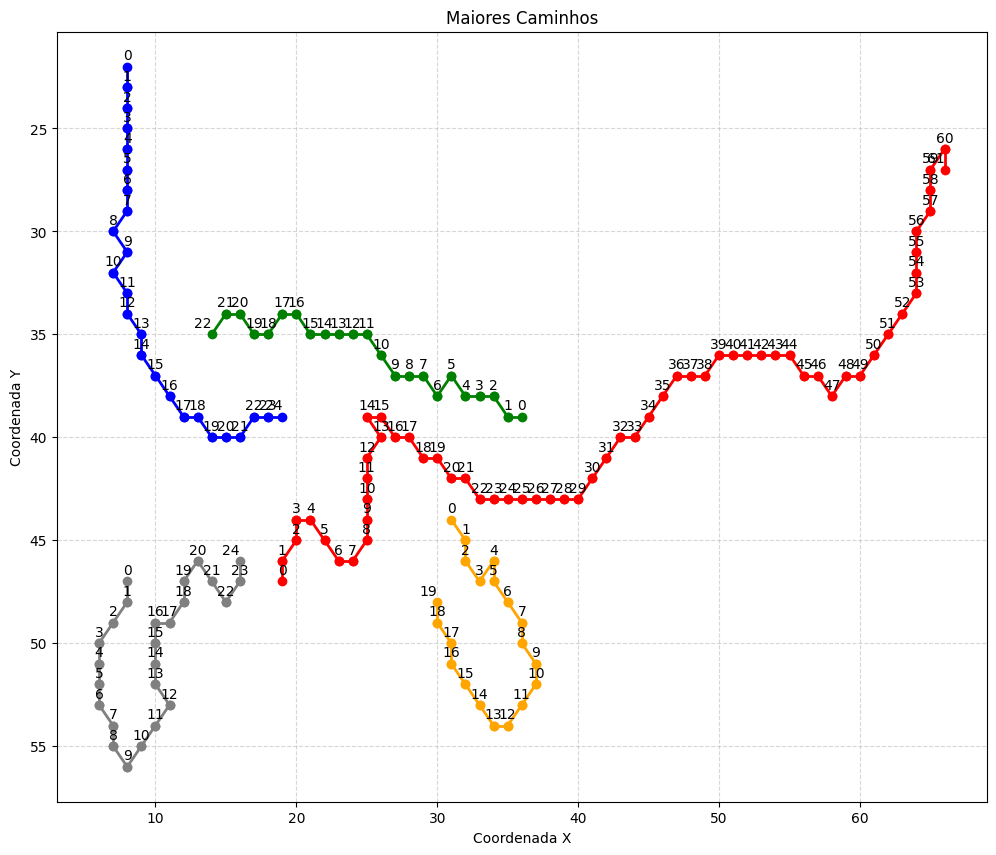

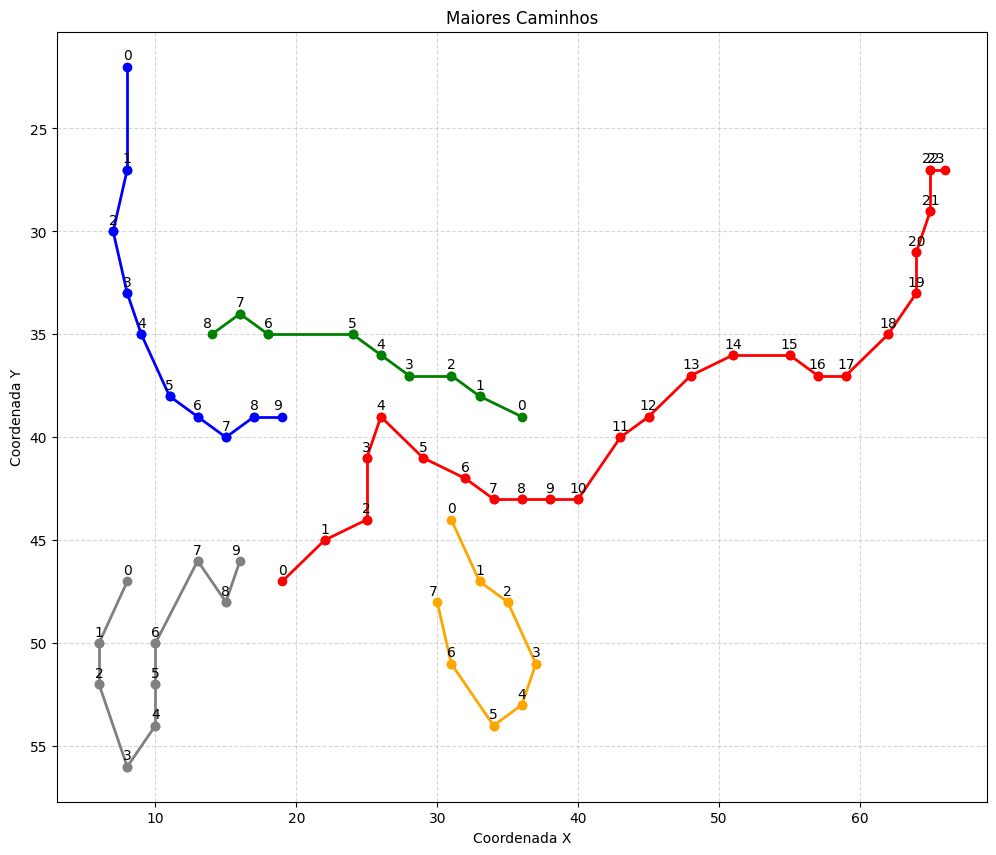

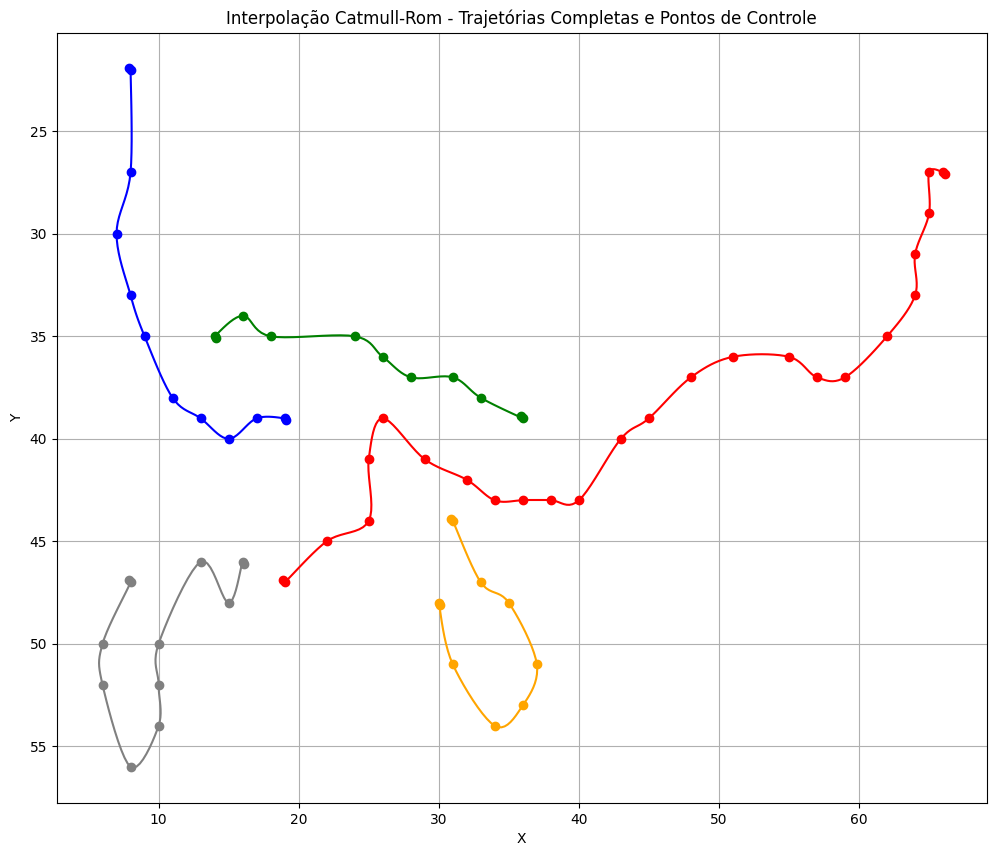

In [5]:
highlight_components(results[0][2].nose_dict, results[0][4].dic_main_nose_cc)
plot_logest_path(results[0][2].nose_dict, results[0][6].longest_path_nose, results[0][5].nodes_nose)
plot_logest_path(results[0][2].nose_dict, results[0][6].new_longest_path_nose, results[0][5].nodes_nose)
plot_splines(results[0][7].all_X_nose, results[0][7].all_Y_nose, results[0][7].all_control_x_nose, results[0][7].all_control_y_nose)


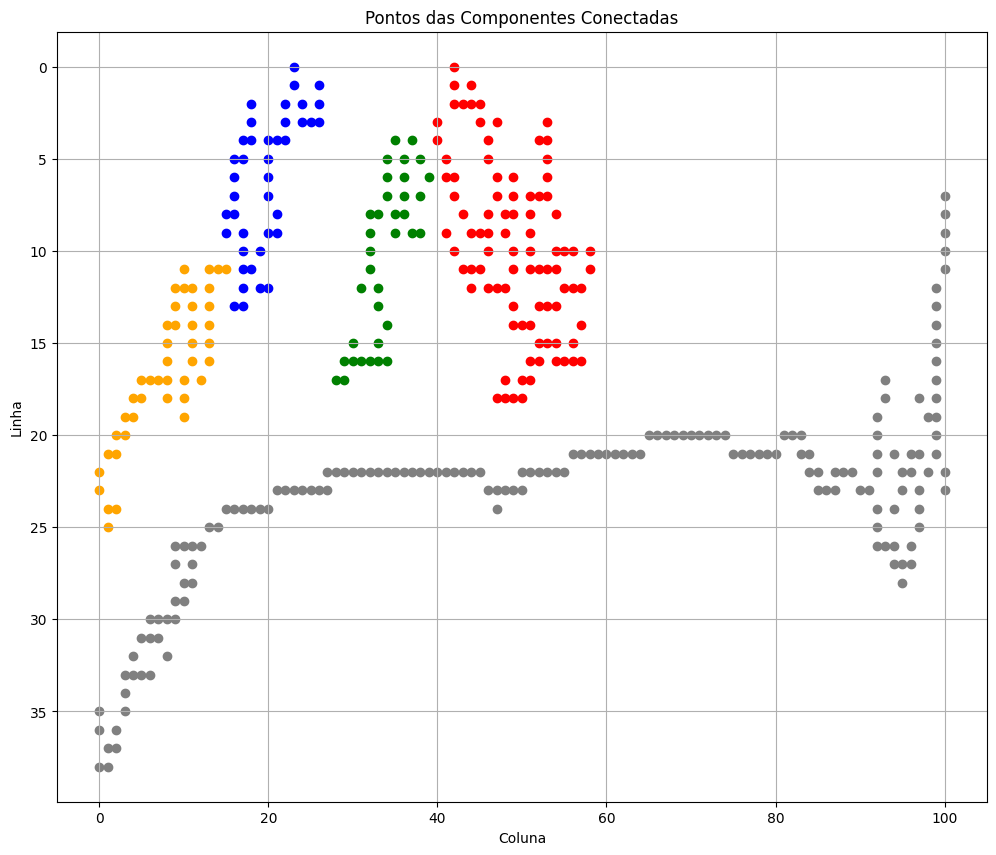

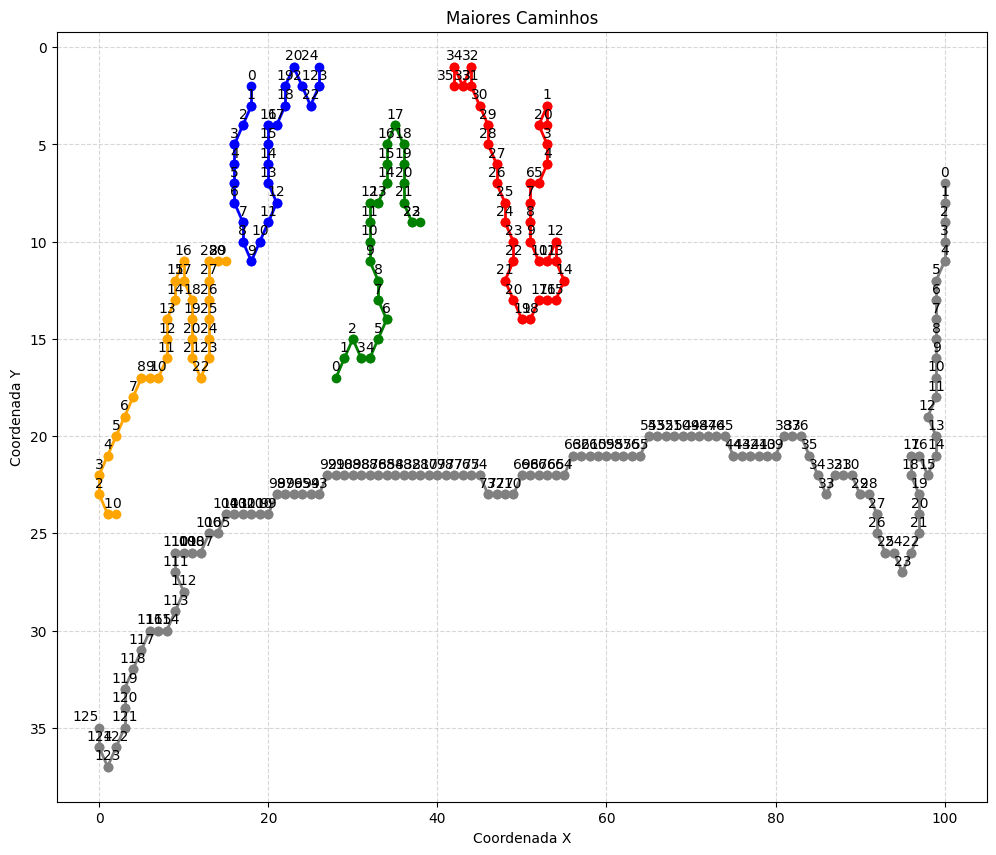

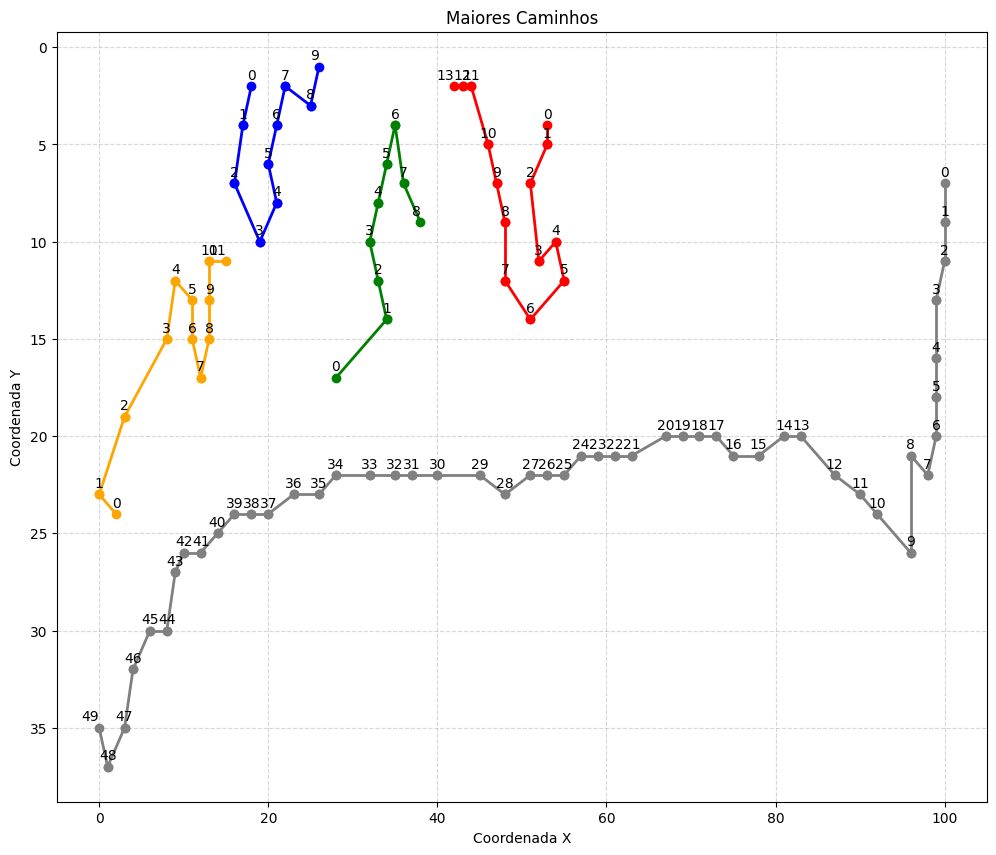

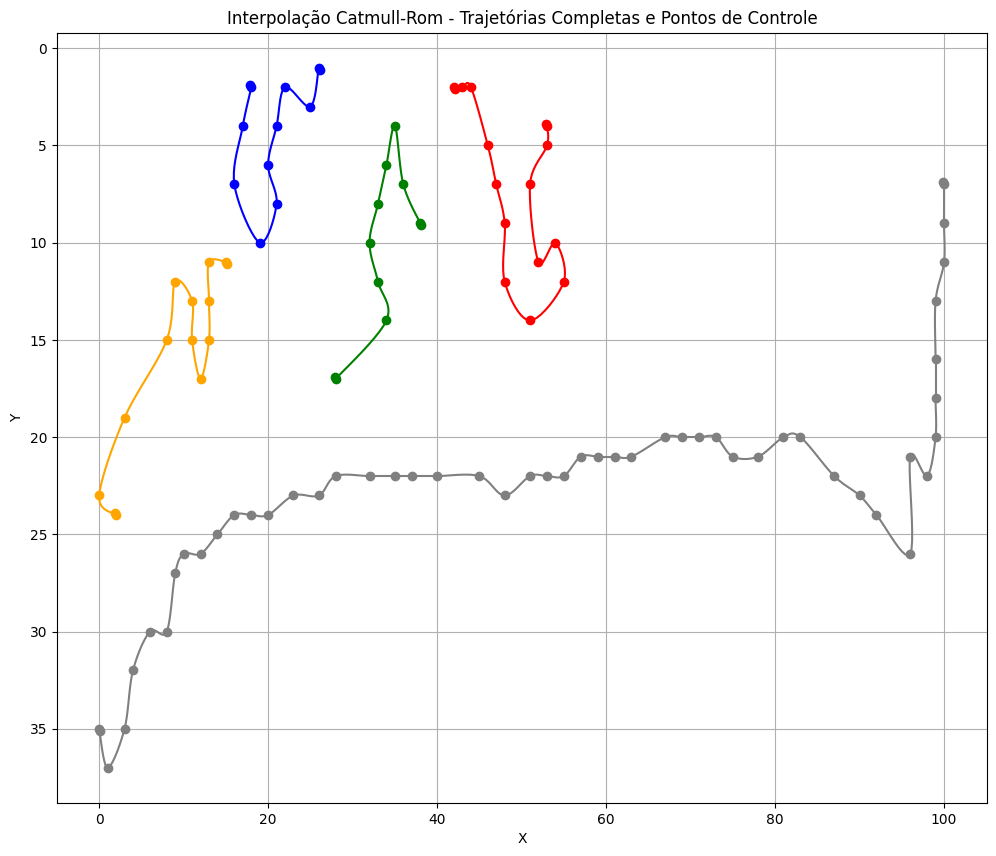

In [6]:

highlight_components(results[0][2].mouth_dict, results[0][4].dic_main_mouth_cc)
plot_logest_path(results[0][2].mouth_dict, results[0][6].longest_path_mouth, results[0][5].nodes_mouth)
plot_logest_path(results[0][2].mouth_dict, results[0][6].new_longest_path_mouth, results[0][5].nodes_mouth)
plot_splines(results[0][7].all_X_mouth, results[0][7].all_Y_mouth, results[0][7].all_control_x_mouth, results[0][7].all_control_y_mouth)